**MID EXAM Computer Vision**

**Nomor 4**

Nama  : Rio Pramana

NIM   : 2440016804

Kelas : LA01

Penjelasan akan diberikan pada markdown cell dan juga comment pada code

# Idea of Harris Corner Detection

The idea of this algorithm is to detect corners using a small window around pixels in the image.

Contoh ilustrasi:
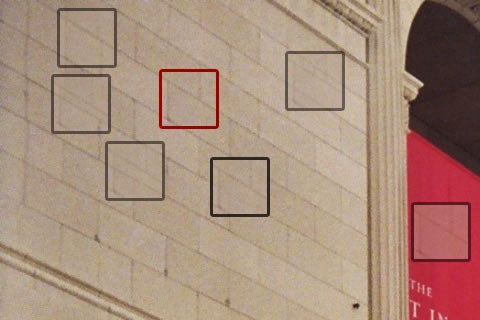

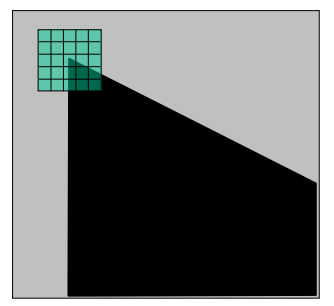

We will shift the window by a small amount each time. If there is a huge change in the pixel values/intensity in all directions, then we can assume that it is potentially a corner

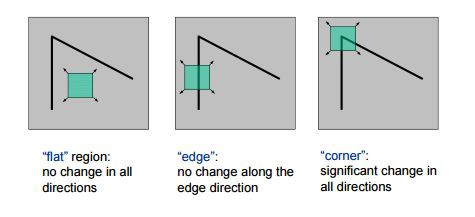

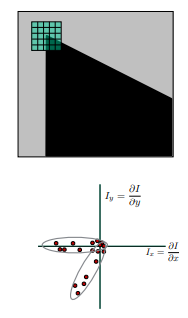

Reference for the illustration: https://medium.com/data-breach/introduction-to-harris-corner-detector-32a88850b3f6 & https://www.cs.cmu.edu/~16385/s17/Slides/6.2_Harris_Corner_Detector.pdf

# Implementing Harris Corner Detection Algorithm

### Import libraries

In [1]:
#Import libraries
import numpy as np
import cv2
from matplotlib import pyplot as plt

### Read and transform image into grayscale

Pada kasus ini, saya akan menggunakan gambar sebuah chess board untuk dideteksi cornersnya

In [2]:
#Load image from files
img = cv2.imread('chess_board.jpg') #read the image

#Transform into RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Transform the image into grayscale
#Because we will need the original image, I will separate the grayscale image to a new variable
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

Visualisasi:

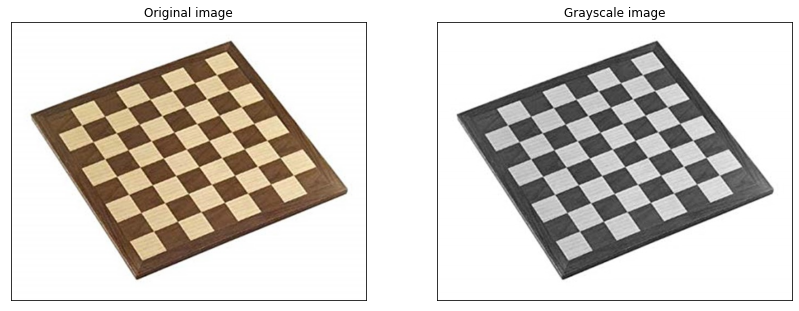

In [3]:
# Display the images
fig = plt.figure(figsize=(14,10))

# Original image
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Original image'), plt.xticks([]), plt.yticks([])

# Bandpass filtered image
plt.subplot(122),plt.imshow(img_gray, cmap = 'gray')
plt.title('Grayscale image'), plt.xticks([]), plt.yticks([])

plt.show()

## A. Compute Gaussian derivatives at each pixel

To compute Gaussian derivatives at each pixel, there are usually 2 steps needed to be done, they are:

1. Compute x & y derivatives of image (Ix & Iy)
2. Compute products of derivatives at every pixel (Ixx, Iyy, Ixy)

Before computing the Gaussian derivatives, I will blur the image first the reduce the noise

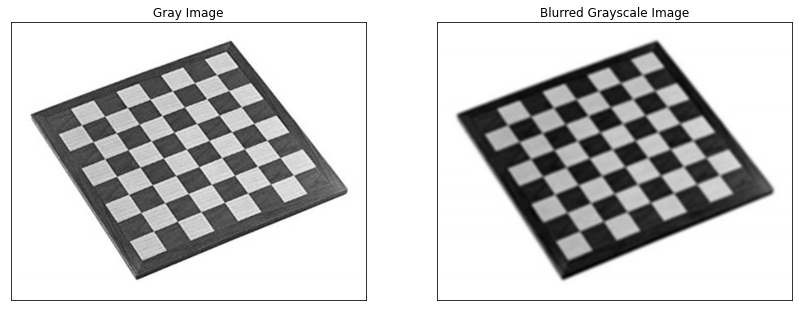

In [4]:
# Before we compute Gaussian derivatives, we have the option to blur the image first

# In this case, I will use a Gaussian filter provided by open-cv
# The size of the kernel will be 9 x 9 and the Sigma will be 3 (an attempt to make it more blurry)
img_blur = cv2.GaussianBlur(img_gray,(9,9),3)

# Display the image
fig = plt.figure(figsize=(14,10))

# Gray image
plt.subplot(121),plt.imshow(img_gray, cmap = 'gray')
plt.title('Gray Image'), plt.xticks([]), plt.yticks([])

# Blurred gray image
plt.subplot(122),plt.imshow(img_blur, cmap = 'gray')
plt.title('Blurred Grayscale Image'), plt.xticks([]), plt.yticks([])
plt.show()

Computing using Sobel:

In [5]:
# For the first step, I will use Sobel filter (using the one provided by open-cv)..
# ..to compute x & y derivatives of image (x & y gradients)

# The kernel size of the Sobel filter is set to 9 (9 x 9)
I_x = cv2.Sobel(img_blur, cv2.CV_64F, 1, 0, ksize=9)
I_y = cv2.Sobel(img_blur, cv2.CV_64F, 0, 1, ksize=9)

In [6]:
# The second step is just computing products of derivatives at every pixel
# To do this, we just need to compute (I_x * I_x), (I_y * I_y), and (I_x * I_y)

I_xx = np.multiply(I_x, I_x)
I_yy = np.multiply(I_y, I_y)
I_xy = np.multiply(I_x, I_y)

## B. Compute second moment matrix M in a Gaussian window around each pixel

The second moment matrix M at each pixel can be defined as shown in the image below:

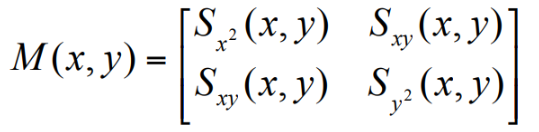

To get this matrix, we need to compute the sums of the products of derivatives at each pixel (Sxx, Syy, Sxy)

In [7]:
# This step only includes computing the sums of the products of derivatives at each pixel
# We can do this by applying a Gaussian filter to I_xx, I_yy, and I_xy
# This step will give us the products of gradient components needed to build the..
# ..second moment matrix M

# In this case, I will use a Gaussian filter provided by open-cv (cv2.GaussianBlur())
# Size of the kernel is 9 x 9 with sigmaX and sigmaY = 3
S_xx = cv2.GaussianBlur(I_xx,(9, 9), 3)
S_yy = cv2.GaussianBlur(I_yy,(9, 9), 3)
S_xy = cv2.GaussianBlur(I_xy,(9, 9), 3)

## C. Compute corner response function R

To compute R, we just need to compute determinant and trace of matrix M first, and then decide on the value of k (sensitivity factor to separate corners from edges)

The formula for R is shown in the image below:

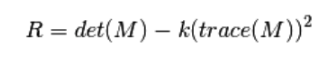

In [8]:
# First, calculate determinant and trace of M
det_M = np.multiply(S_xx, S_yy) - np.multiply(S_xy, S_xy)
trace_M = np.add(S_xx, S_yy)

# Next, decide on the value of k
k = 0.03 # Because I am looking for a sharp corner (based on the shapes in a chess board), I set it to a really low value

# Finally, compute R
R = det_M - k * (np.square(trace_M))

## D. Threshold R

To find corners, I will set the threshold to be r > 0 (r > 0 will indicate that it is a corner)

In [9]:
# Create a new variable to hold a picture with just the thresholded R
thresholded = np.zeros(img.shape)

# Iterate through R to check each r and get corners
for row_index, response in enumerate(R):
    for col_index, r in enumerate(response):
        if r > 0:
            # If it is a corner (r > 0), set the color to red
            thresholded[row_index, col_index] = [255,0,0] #Using RGB, red is (255,0,0)

Visualize the thresholded R:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


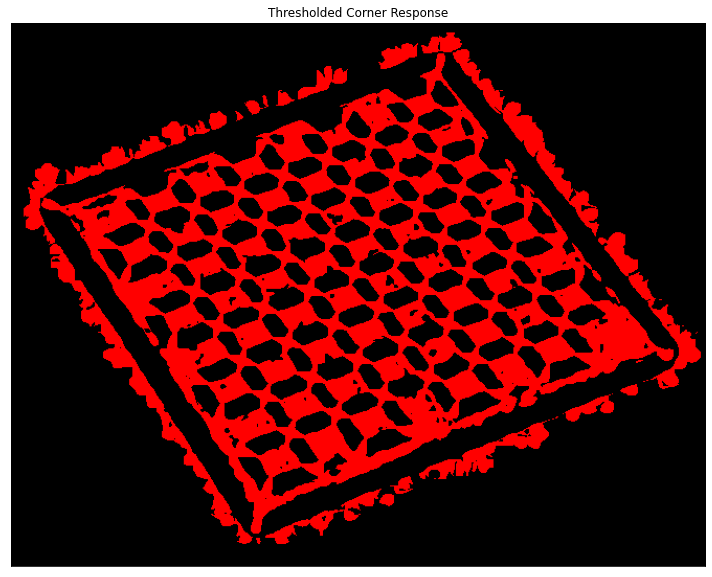

In [10]:
# Display the image
fig = plt.figure(figsize=(14,10))

# Thresholded R
plt.imshow(thresholded)
plt.title('Thresholded Corner Response'), plt.xticks([]), plt.yticks([])

plt.show()

## E. Find local maxima of response function (non-maximum suppression)

To identify the real corners, we need to perform non-maximum suppression (The same is done when we are trying to find real edges by performing non-maximum suppression to thin out the edges that were detected as in question number 3)

The difference is, this time, I am going to set another threshold to determine the corners (whereas when we identify edges, we check every pixel adjacent to the pixel we are currently checking).

After some trial & error, I decided that a threshold of 5% of maximum value produces a good enough result

In [11]:
# Copy the thresholded R result, perform non-maximum suppression on it
thresholded_suppressed = np.copy(thresholded)
# Set the new threshold for non-maximum suppression
max_value = 0.05 * R.max() # 5% of max value

for row_index,row in enumerate(R):
    for col_index,col in enumerate(row):
        if col > max_value:
            # If it is more than threshold, keep it as a corner
            pass
        else:
            # If it is less than threshold, then suppress it
            thresholded_suppressed[row_index,col_index] = [0,0,0] # Make it black

Visualize the non-maximum suppression result:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


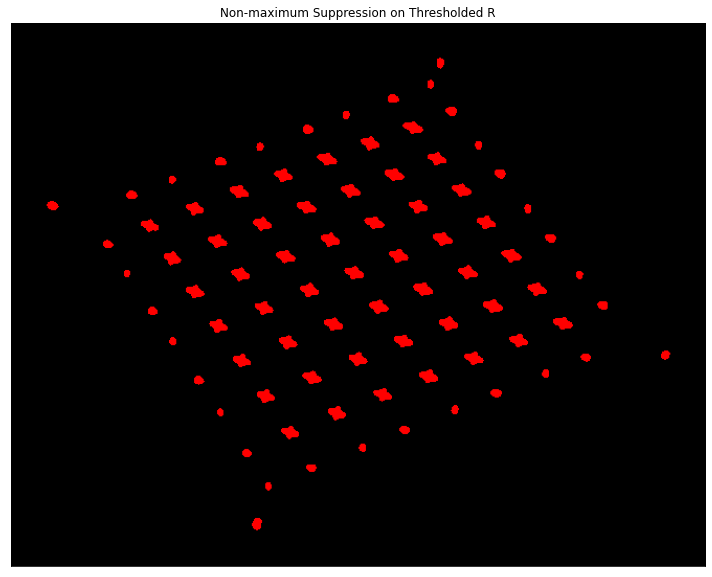

In [12]:
# Display the image
fig = plt.figure(figsize=(14,10))

# Suppressed thresholded R image
plt.imshow(thresholded_suppressed)
plt.title('Non-maximum Suppression on Thresholded R'), plt.xticks([]), plt.yticks([])

plt.show()

## Visualize corners found on the original image

To show the corners on the original image, we can change the pixels colors on the original image to red according to the position of the corners

The way I'm going to do it is by iterating through the suppressed image, if it is colored red, then get the row & column index to change the original image pixel (with that exact index) to red as well

In [13]:
# Original image with corners shown
img_with_suppressed = np.copy(img)

# Iterate
for row_index,row in enumerate(R):
    for col_index,col in enumerate(row):
        # If the current index is suppressed image is red..
        if (thresholded_suppressed[row_index,col_index] == [255,0,0]).all():
            # ..change the original image to red as well
            img_with_suppressed[row_index,col_index] = [255,0,0] 
        else:
            pass

Visualize final image:

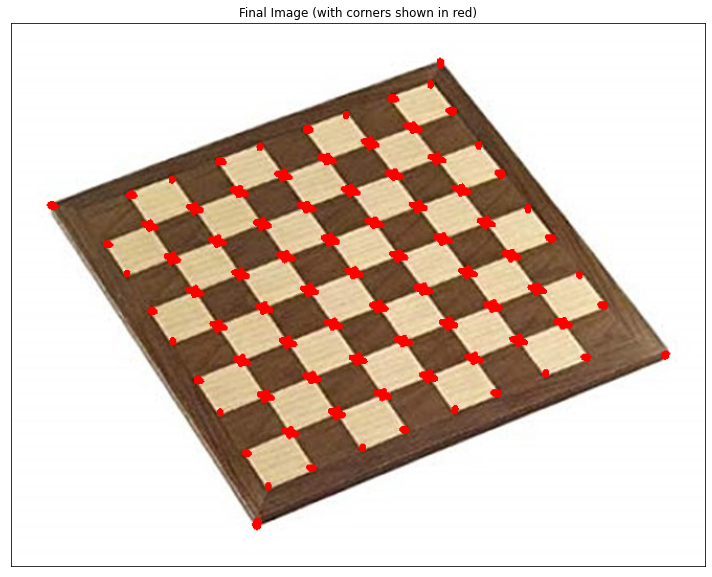

In [14]:
# Display final image
fig = plt.figure(figsize=(14,10))
plt.imshow(img_with_suppressed, cmap = 'gray')
plt.title('Final Image (with corners shown in red)'), plt.xticks([]), plt.yticks([])

plt.show()